In [2]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model
from multiprocessing import Pool
import healpy as hp
from astropy.coordinates import SkyCoord
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# %matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d    
import random
from sklearn.svm import SVC
from sklearn import svm

from alive_progress import alive_it
from tqdm import tqdm

In [3]:
def generate_df(i):
     # Importing the dataset containing optical clusters
    df = pd.read_csv('awd.csv', skiprows = 0, index_col=0)
    df['intensity100'] = np.loadtxt('../data/new2/planck_real_100.csv',delimiter=', ')
    df['intensity143'] = np.loadtxt('../data/new2/planck_real_143.csv',delimiter=', ')
    df['intensity217'] = np.loadtxt('../data/new2/planck_real_217.csv',delimiter=', ')
    df['intensity353'] = np.loadtxt('../data/new2/planck_real_353.csv',delimiter=', ')
    df['intensity545'] = np.loadtxt('../data/new2/planck_real_545.csv',delimiter=', ')
    df['intensity857'] = np.loadtxt('../data/new2/planck_real_857.csv',delimiter=', ')
    df['intensity090_act'] = np.loadtxt('../data/new2/090_real.csv',delimiter=', ')
    df['intensity150_act'] = np.loadtxt('../data/new2/150_real.csv',delimiter=', ')
    df['intensity220_act'] = np.loadtxt('../data/new2/220_real.csv',delimiter=', ')
    df['intensity_rosat'] = np.loadtxt('../data/new2/rosat_real.csv',delimiter=', ')
    df['cluster'] = 1    
    df = df[(df.intensity090_act!=-9999)&(df.intensity150_act!=-9999)&(df.intensity220_act!=-9999)]
    
    # Importing the dataset containing non-clusters
    df2 = pd.read_csv('../data/voids_complete.csv', skiprows = 0, index_col=0)
    df2['intensity100'] = np.loadtxt('../data/new/planck_100_rv2_0.csv',delimiter=', ')
    df2['intensity143'] = np.loadtxt('../data/new/planck_143_rv1_0.csv',delimiter=', ')
    df2['intensity217'] = np.loadtxt('../data/new/planck_217_rv0_0.csv',delimiter=', ')
    df2['intensity353'] = np.loadtxt('../data/new/planck_353_2_0.csv',delimiter=', ')
    df2['intensity545'] = np.loadtxt('../data/new2/planck_voids_545.csv',delimiter=', ')
    df2['intensity857'] = np.loadtxt('../data/new2/planck_voids_857.csv',delimiter=', ')
    df2['intensity090_act'] = np.loadtxt('../data/new2/090_voids.csv',delimiter=', ')
    df2['intensity150_act'] = np.loadtxt('../data/new2/150_voids.csv',delimiter=', ')
    df2['intensity220_act'] = np.loadtxt('../data/new2/220_voids.csv',delimiter=', ')
    df2['intensity_rosat'] = np.loadtxt('../data/new/rosat_voids.csv',delimiter=', ')
    df2 = df2[(df2.intensity090_act!=-9999)&(df2.intensity150_act!=-9999)&(df2.intensity220_act!=-9999)]
    
    df2_scaled_up = df2.copy()
    df2_scaled_up['intensity090_act'] = df2['intensity090_act']*i
    df2_scaled_up['intensity100'] = df2['intensity100']*i
    df2_scaled_up['intensity143'] = df2['intensity143']*i
    df2_scaled_up['intensity150_act'] = df2['intensity150_act']*i
    df2_scaled_up['intensity217'] = df2['intensity217']*i
    df2_scaled_up['intensity220_act'] = df2['intensity220_act']*i
    df2_scaled_up['intensity353'] = df2['intensity353']*i
    df2_scaled_up['intensity545'] = df2['intensity545']*i
    df2_scaled_up['intensity857'] = df2['intensity857']*i
    df2_scaled_up['intensity_rosat'] = df2['intensity_rosat']*i

    df2_scaled_down = df2.copy()
    df2_scaled_down['intensity090_act'] = df2['intensity090_act']/i
    df2_scaled_down['intensity100'] = df2['intensity100']/i
    df2_scaled_down['intensity143'] = df2['intensity143']/i
    df2_scaled_down['intensity150_act'] = df2['intensity150_act']/i
    df2_scaled_down['intensity217'] = df2['intensity217']/i
    df2_scaled_down['intensity220_act'] = df2['intensity220_act']/i
    df2_scaled_down['intensity353'] = df2['intensity353']/i
    df2_scaled_down['intensity545'] = df2['intensity545']/i
    df2_scaled_down['intensity857'] = df2['intensity857']/i
    df2_scaled_down['intensity_rosat'] = df2['intensity_rosat']/i
    
    df2 = pd.concat([df2, df2_scaled_up, df2_scaled_down])
    
    # Combine real and fake data
    # df3 = df.append(df2, ignore_index=True)
    df3 = df.append(df2, ignore_index=True)
    
    return df,df2,df3

In [4]:
def make_algo(df,df2,df3):
    # From the signal in the 100Ghz image and 353Ghz image, determine the expected signal in 143Ghz
    # 50 percent of the sample has richness over 27, use the richer sample for training
    intensity_clusters = df[(df.intensity090_act!=-9999)&(df.intensity150_act!=-9999)&(df.intensity220_act!=-9999)][['intensity090_act','intensity100','intensity143','intensity150_act','intensity217','intensity220_act','intensity353','intensity545','intensity857','intensity_rosat']][::2]
    intensity_voids = df2[(df2.intensity090_act!=-9999)&(df2.intensity150_act!=-9999)&(df2.intensity220_act!=-9999)][['intensity090_act','intensity100','intensity143','intensity150_act','intensity217','intensity220_act','intensity353','intensity545','intensity857','intensity_rosat']][::2]
    intensity_combined = df3[(df3.intensity090_act!=-9999)&(df3.intensity150_act!=-9999)&(df3.intensity220_act!=-9999)][['intensity090_act','intensity100','intensity143','intensity150_act','intensity217','intensity220_act','intensity353','intensity545','intensity857','intensity_rosat']][::2]

    cluster_tag = df3[(df3.intensity090_act!=-9999)&(df3.intensity150_act!=-9999)&(df3.intensity220_act!=-9999)]['cluster'][::2]

    # Fit full sample with their associated classficiation
    clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    clf.fit(intensity_combined, cluster_tag)
    
    return intensity_clusters, intensity_voids, intensity_combined, clf

In [5]:
# Csv importer wrapped in a function that can be mapped for parallelization
def read_csv(filename):
    return pd.DataFrame(np.loadtxt(filename,delimiter=', ')).T

In [6]:
def read_in_intensity():  
    fsky = pd.read_csv('full_sky.csv', skiprows = 0, index_col=0)

---

# Classification of clusters vs non clusters

In [16]:
def driver(alpha):
    df,df2,df3 = generate_df(alpha)
    intensity_clusters, intensity_voids, intensity_combined, clf = make_algo(df,df2,df3)
    
    cluster = np.array([clf.predict([[i090, i100, i143, i150, i217, i220, i353, i545, i857, irosat]]) for i090, i100, i143, i150, i217, i220, i353, i545, i857, irosat in intensity_clusters[1::2].values]).flatten() 
    no_cluster = np.array([clf.predict([[i090, i100, i143, i150, i217, i220, i353, i545, i857, irosat]]) for i090, i100, i143, i150, i217, i220, i353, i545, i857, irosat in intensity_voids[1::2].values]).flatten()
    
#     fsky = pd.read_csv('../data/fsky.csv', skiprows = 0, index_col=0)
#     fsky = fsky[(fsky.int090!=-9999)&(fsky.int150!=-9999)&(fsky.int220!=-9999)]
#     cluster_prob = np.array([clf.predict([[i090, i100, i143, i150, i217, i220, i353, i545, i857, irosat]]) for i090, i100, i143, i150, i217, i220, i353, i545, i857, irosat in fsky[['int090','int100','int143','int150','int217','int220','int353','int545','int857','introsat']].values]).flatten()    
#     fsky['cluster'] = cluster_prob
    
#     plt.clf()
#     pl143 = hp.read_map('../data/HFI_SkyMap_143-field-IQU_2048_R3.00_full.fits')
#     hp.mollview(pl143,norm='hist',cmap='Greys',coord=['G'],title='Masked S/N map')
    # hp.visufunc.projscatter(df['glon'],df['glat'],c='red',lonlat=True,s=0.01)
    # hp.visufunc.projscatter(df2['glon'],df2['glat'],c='blue',lonlat=True,s=0.01)
#     hp.visufunc.projscatter(fsky[fsky.cluster<0.5]['glon'],fsky[fsky.cluster<0.5]['glat'],c="darkblue",s=5)
#     hp.visufunc.projscatter(fsky[fsky.cluster>0.5]['glon'],fsky[fsky.cluster>0.5]['glat'],c="magenta",s=5)

    plt.hist(cluster,bins=100,range=(0,1),density=True,alpha=0.8,label='real')
    plt.hist(no_cluster,bins=100,range=(0,1),density=True,facecolor='red',alpha=0.5,label='voids')
    plt.legend()
    plt.title("Classification of clusters/voids for alpha={}".format(alpha))
    plt.show()
    
#     plt.scatter(fsky['glon'],fsky['glat'],c=fsky.cluster,cmap='plasma',s=1)
#     plt.show()
#     plt.savefig("{}.png".format(alpha))  

#     frac = len(fsky[fsky.cluster==0])/len(fsky)
#     print(frac)
    frac = len(no_cluster[no_cluster<0.5])/len(no_cluster)
    frac2 = len(cluster[cluster<0.5])/len(cluster)
    print(frac,frac2)
    return clf, frac,frac2

  0%|          | 0/10 [00:00<?, ?it/s]

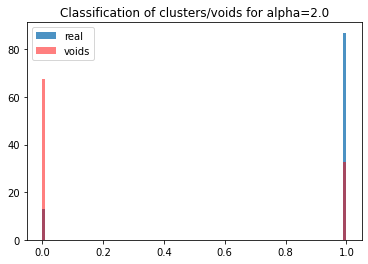

 10%|█         | 1/10 [00:24<03:43, 24.82s/it]

0.6749866286325549 0.12952424311404506


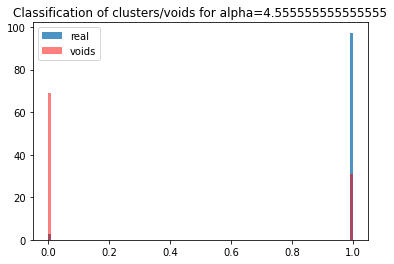

 20%|██        | 2/10 [00:47<03:06, 23.29s/it]

0.6901408450704225 0.026860915092192125


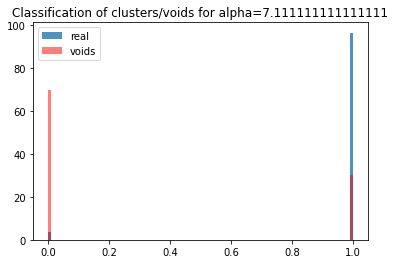

 30%|███       | 3/10 [01:09<02:41, 23.03s/it]

0.6967373863433767 0.03664921465968586


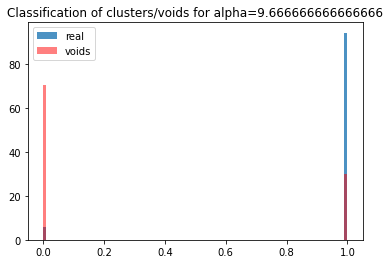

 40%|████      | 4/10 [01:33<02:20, 23.36s/it]

0.7027990729185238 0.058957432278625085


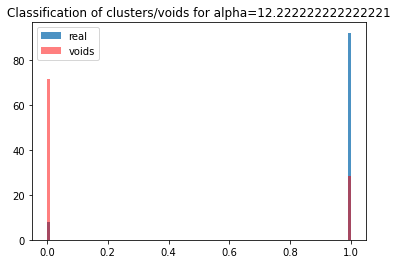

 50%|█████     | 5/10 [01:54<01:51, 22.33s/it]

0.7140310215724728 0.07830639653994992


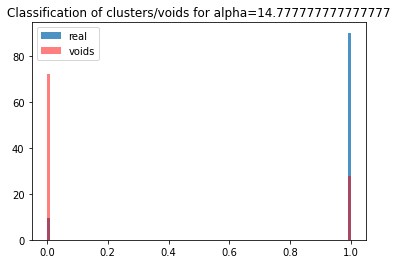

 60%|██████    | 6/10 [02:15<01:28, 22.03s/it]

0.7233018363344624 0.09651718643296153


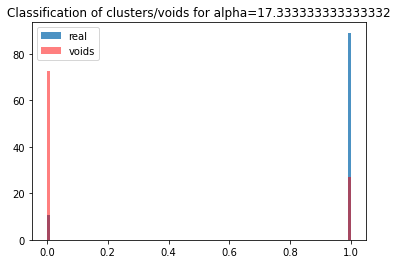

 70%|███████   | 7/10 [02:36<01:04, 21.56s/it]

0.7284720984132644 0.10858183473708172


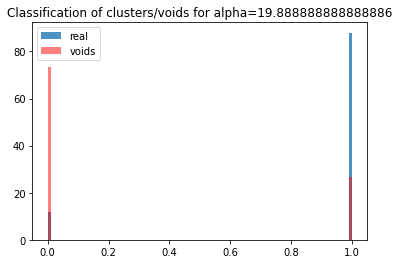

 80%|████████  | 8/10 [02:57<00:42, 21.44s/it]

0.7352469245854876 0.12019121329387662


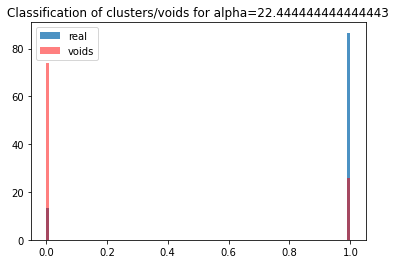

 90%|█████████ | 9/10 [03:19<00:21, 21.51s/it]

0.7404171866642896 0.13362167083997267


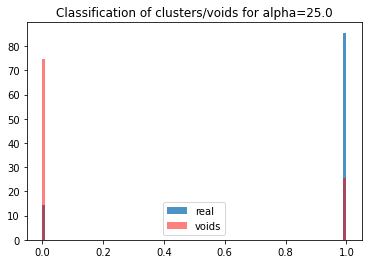

100%|██████████| 10/10 [03:40<00:00, 22.09s/it]

0.7457657336423605 0.14409287502845436


In [28]:
fracs = []
fracs2 = []
for alpha in tqdm(np.linspace(2,25,10)):
    clf, frac, frac2 = driver(alpha)
    fracs.append(frac)
    fracs2.append(frac2)

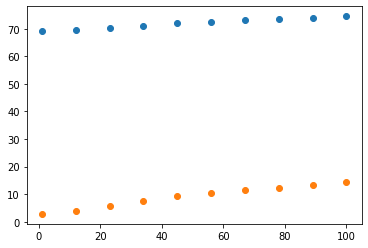

In [27]:
plt.scatter(np.linspace(1,100,10),np.array(fracs)*100)
plt.scatter(np.linspace(1,100,10),np.array(fracs2)*100)

In [15]:
fracs

[0.883045106079515,
 0.6749866286325549,
 0.6876448564806561,
 0.6910322695667677,
 0.6904974148689605,
 0.6922802638616509]

---

/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/healpy/projaxes.py:209: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  **kwds


0.9837666666666667


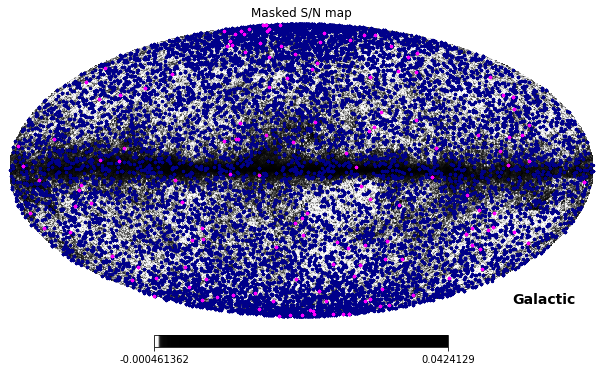

In [15]:
clf,fracs = driver(3)

(-0.001, 0.001)

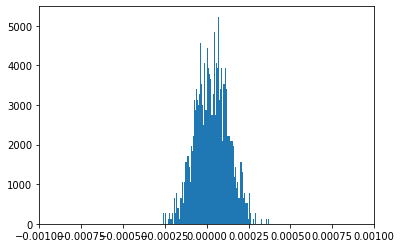

In [75]:
plt.hist(df[:1208]['intensity100'],bins=100,density=True)
plt.xlim(-0.001,0.001)

In [13]:
clf.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [14]:
support_indices = np.cumsum(clf.n_support_)

In [68]:
len(clf.dual_coef_[0:support_indices[0]][0])

5332

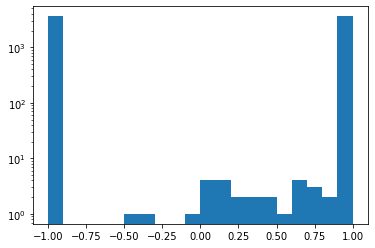

In [35]:
plt.hist(clf.dual_coef_[0:support_indices[0]][0],bins=20)
plt.yscale('log')